In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
!pip install nvcc4jupyter

In [3]:
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpp9d0cohl".


# Sequential

In [4]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <math.h>
#include <sys/time.h>

#define M_PI 3.14159265358979323846

int **generateGrayscaleImage(int width, int height)
{
    srand(1234);

    int **image = (int **)malloc(height * sizeof(int *));
    if (image == NULL)
    {
        printf("memory allocation failed.\n");
        return NULL;
    }

    for (int i = 0; i < height; i++)
    {
        image[i] = (int *)malloc(width * sizeof(int));
        if (image[i] == NULL)
        {
            printf("memory allocation failed.\n");

            for (int j = 0; j < i; j++)
            {
                free(image[j]);
            }
            free(image);
            return NULL;
        }
    }

    for (int i = 0; i < height; i++)
    {
        for (int j = 0; j < width; j++)
        {
            image[i][j] = rand() % 256;
        }
    }
    return image;
}

void freeImage(int **image, int height)
{
    for (int i = 0; i < height; i++)
    {
        free(image[i]);
    }
    free(image);
}

double **generateGaussianKernel(int k, double sigma)
{
    double **kernel = (double **)malloc(k * sizeof(double *));
    if (kernel == NULL)
    {
        printf("memory allocation failed.\n");
        return NULL;
    }

    int c = k / 2;
    double norm = 0.0;

    for (int i = 0; i < k; i++)
    {
        kernel[i] = (double *)malloc(k * sizeof(double));
        if (kernel[i] == NULL)
        {
            printf("memory allocation failed.\n");
            for (int j = 0; j < i; j++)
            {
                free(kernel[j]);
            }
            free(kernel);
            return NULL;
        }

        for (int j = 0; j < k; j++)
        {
            double x = j - c;
            double y = i - c;

            kernel[i][j] = exp(-(x * x + y * y) / (2 * sigma * sigma)) / (2 * M_PI * sigma * sigma);

            norm += kernel[i][j];
        }
    }

    for (int i = 0; i < k; i++)
    {
        for (int j = 0; j < k; j++)
        {
            kernel[i][j] /= norm;
        }
    }
    return kernel;
}

void applyGaussianKernel(double** kernel, int kernelSize, int width, int height, int** image, int** outputImage) {
    int border = kernelSize / 2;

    for (int y = 0; y < height; y++) {
        for (int x = 0; x < width; x++) {
            double sum = 0.0;

            for (int i = -border; i <= border; i++) {
                for (int j = -border; j <= border; j++) {
                    int offsetX = x + j;
                    int offsetY = y + i;

                    if (offsetX < 0 || offsetX >= width || offsetY < 0 || offsetY >= height) {
                        sum += 0.0;
                    } else {
                        sum += kernel[i + border][j + border] * image[offsetY][offsetX];
                    }
                }
            }
            outputImage[y][x] = (int)sum;
        }
    }
}

int main()
{
    int width = 5; // Change width, height and kernel size from here
    int height = 5;
    int k = 3;
    double sigma = 1.0;

    int **image = generateGrayscaleImage(width, height);
    if (image == NULL) {
        return 1;
    }

    int **outputImage = (int **)malloc(height * sizeof(int *));
    if (outputImage == NULL) {
        printf("memory allocation failed.\n");
        return 1;
    }
    for (int i = 0; i < height; i++) {
        outputImage[i] = (int *)malloc(width * sizeof(int));
        if (outputImage[i] == NULL) {
            printf("memory allocation failed.\n");

            for (int j = 0; j < i; j++) {
                free(outputImage[j]);
            }
            free(outputImage);
            return 1;
        }
    }

    double** gaussianKernel = generateGaussianKernel(k, sigma);
    if (gaussianKernel == NULL) {
        for (int i = 0; i < height; i++) {
            free(image[i]);
            free(outputImage[i]);
        }
        free(image);
        free(outputImage);
        return 1;
    }

    // Start measuring time
    struct timeval begin, end;
    gettimeofday(&begin, 0);

    applyGaussianKernel(gaussianKernel, k, width, height, image, outputImage);

    // Stop measuring time and calculate the elapsed time
    gettimeofday(&end, 0);
    long seconds = end.tv_sec - begin.tv_sec;
    long microseconds = end.tv_usec - begin.tv_usec;
    double elapsed = seconds + microseconds * 1e-6;

    printf("Original Image:\n");
    for (int i = 0; i < height; i++) {
        for (int j = 0; j < width; j++) {
            printf("%d ", image[i][j]);
        }
        printf("\n");
    }

    printf("\n");

    printf("Filtered Image:\n");
    for (int i = 0; i < height; i++) {
        for (int j = 0; j < width; j++) {
            printf("%d ", outputImage[i][j]);
        }
        printf("\n");
    }

    printf("Time measured: %.6f seconds.\n", elapsed);

    for (int i = 0; i < height; i++) {
        free(image[i]);
        free(outputImage[i]);
    }
    free(image);
    free(outputImage);

    for (int i = 0; i < k; i++) {
        free(gaussianKernel[i]);
    }
    free(gaussianKernel);

    return 0;
}

Original Image:
14 131 11 115 236 
245 75 74 116 53 
231 241 6 65 200 
107 170 223 12 61 
230 76 72 161 219 

Filtered Image:
55 63 56 77 77 
117 120 82 95 92 
139 157 103 85 72 
123 155 118 102 82 
82 98 85 91 73 
Time measured: 0.000002 seconds.



# Parallel Without Shared Memory

In [5]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <math.h>
#include <sys/time.h>

#define M_PI 3.14159265358979323846
#define BLOCK_SIZE 16

__global__ void applyGaussianKernelCUDA(double *kernel, int kernelSize, int width, int height, int *image, int *outputImage) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height) {
        int border = kernelSize / 2;
        double sum = 0.0;

        for (int i = -border; i <= border; i++) {
            for (int j = -border; j <= border; j++) {
                int offsetX = x + j;
                int offsetY = y + i;

                if (offsetX >= 0 && offsetX < width && offsetY >= 0 && offsetY < height) {
                    sum += kernel[(i + border) * kernelSize + (j + border)] * image[offsetY * width + offsetX];
                }
            }
        }
        outputImage[y * width + x] = (int)sum;
    }
}

int *generateGrayscaleImage(int width, int height) {
    srand(1234);

    int *image = (int *)malloc(width * height * sizeof(int));
    if (image == NULL) {
        printf("memory allocation failed.\n");
        return NULL;
    }

    for (int i = 0; i < width * height; i++) {
        image[i] = rand() % 256;
    }
    return image;
}

double *generateGaussianKernel(int k, double sigma) {
    double *kernel = (double *)malloc(k * k * sizeof(double));
    if (kernel == NULL) {
        printf("memory allocation failed.\n");
        return NULL;
    }

    int c = k / 2;
    double norm = 0.0;

    for (int i = 0; i < k; i++) {
        for (int j = 0; j < k; j++) {
            double x = j - c;
            double y = i - c;

            kernel[i * k + j] = exp(-(x * x + y * y) / (2 * sigma * sigma)) / (2 * M_PI * sigma * sigma);

            norm += kernel[i * k + j];
        }
    }

    for (int i = 0; i < k * k; i++) {
        kernel[i] /= norm;
    }
    return kernel;
}

int main() {
    int width = 5; // Change width, height and kernel size from here
    int height = 5;
    int k = 3;
    double sigma = 1.0;

    int *image = generateGrayscaleImage(width, height);
    if (image == NULL) {
        return 1;
    }

    int *outputImage = (int *)malloc(width * height * sizeof(int));
    if (outputImage == NULL) {
        printf("memory allocation failed.\n");
        free(image);
        return 1;
    }

    double *gaussianKernel = generateGaussianKernel(k, sigma);
    if (gaussianKernel == NULL) {
        free(image);
        free(outputImage);
        return 1;
    }

    int *d_image, *d_outputImage;
    double *d_gaussianKernel;
    cudaMalloc((void **)&d_image, width * height * sizeof(int));
    cudaMalloc((void **)&d_outputImage, width * height * sizeof(int));
    cudaMalloc((void **)&d_gaussianKernel, k * k * sizeof(double));
    cudaMemcpy(d_image, image, width * height * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_gaussianKernel, gaussianKernel, k * k * sizeof(double), cudaMemcpyHostToDevice);

    dim3 blockSize(BLOCK_SIZE, BLOCK_SIZE);
    dim3 gridSize((width + BLOCK_SIZE - 1) / BLOCK_SIZE, (height + BLOCK_SIZE - 1) / BLOCK_SIZE);

    // Start measuring time
    struct timeval begin, end;
    gettimeofday(&begin, 0);

    applyGaussianKernelCUDA<<<gridSize, blockSize>>>(d_gaussianKernel, k, width, height, d_image, d_outputImage);
    cudaDeviceSynchronize();

    // Stop measuring time and calculate the elapsed time
    gettimeofday(&end, 0);
    long seconds = end.tv_sec - begin.tv_sec;
    long microseconds = end.tv_usec - begin.tv_usec;
    double elapsed = seconds + microseconds * 1e-6;

    cudaMemcpy(outputImage, d_outputImage, width * height * sizeof(int), cudaMemcpyDeviceToHost);

    printf("Original Image:\n");
    for (int i = 0; i < height; i++) {
        for (int j = 0; j < width; j++) {
            printf("%d ", image[i * width + j]);
        }
        printf("\n");
    }

    printf("\n");

    printf("Filtered Image:\n");
    for (int i = 0; i < height; i++) {
        for (int j = 0; j < width; j++) {
            printf("%d ", outputImage[i * width + j]);
        }
        printf("\n");
    }

    printf("Time measured: %.6f seconds.\n", elapsed);

    free(image);
    free(outputImage);
    free(gaussianKernel);
    cudaFree(d_image);
    cudaFree(d_outputImage);
    cudaFree(d_gaussianKernel);

    return 0;
}

Original Image:
14 131 11 115 236 
245 75 74 116 53 
231 241 6 65 200 
107 170 223 12 61 
230 76 72 161 219 

Filtered Image:
55 63 56 77 77 
117 120 82 95 92 
139 157 103 85 72 
123 155 118 102 82 
82 98 85 91 73 
Time measured: 0.113154 seconds.



# Parallel With Shared Memory

In [58]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <math.h>
#include <sys/time.h>

#define M_PI 3.14159265358979323846
#define BLOCK_SIZE 32
#define k 3

__global__ void applyGaussianKernelCUDA(double *kernel, int kernelSize, int width, int height, int *image, int *outputImage)
{
    __shared__ int sharedImage[BLOCK_SIZE + 2 * (k / 2)][BLOCK_SIZE + 2 * (k / 2)]; // Shared memory for image data
    __shared__ double sharedKernel[BLOCK_SIZE][BLOCK_SIZE];                                           // Shared memory for kernel

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int bx = blockIdx.x * blockDim.x;
    int by = blockIdx.y * blockDim.y;
    int x = bx + tx;
    int y = by + ty;

    // Load kernel into shared memory
    if (tx < k && ty < k)
    {
        sharedKernel[ty][tx] = kernel[ty * k + tx];
    }

    if(ty>=0 && ty<height && tx>=0 && tx<width){
        sharedImage[ty+(k/2)][tx+(k/2)]=image[y*width+x];
    }

    if (tx == 0 && ty == 0)
    {
        for (int i = BLOCK_SIZE; i < k; i++)
        {
            for (int j = BLOCK_SIZE; j < k; j++)
            {
                sharedKernel[i][j] = kernel[i * k + j];
            }
        }

        for (int i = by - (k / 2); i < by + BLOCK_SIZE + (k / 2); i++)
        {
            for (int j = bx - (k / 2); j < bx; j++)
            {
                if(i>=0 && i<height && j>=0 && j<width){
                    int offY = by - (k / 2);
                    int offX = bx - (k / 2);
                    sharedImage[i-offY][j-offX] = image[i * width + j];
                }
            }
        }

        for (int i = by - (k / 2); i < by + BLOCK_SIZE + (k / 2); i++)
        {
            for (int j = bx + BLOCK_SIZE; j < bx + BLOCK_SIZE + (k / 2); j++)
            {
                if(i>=0 && i<height && j>=0 && j<width){
                    int offY=by - (k / 2);
                    int offX=bx;
                    sharedImage[i-offY][j-offX+(k/2)] = image[i * width + j];
                }
            }
        }

        for (int i = by - (k / 2); i < by; i++)
        {
            for (int j = bx; j < bx + BLOCK_SIZE; j++)
            {
                if(i>=0 && i<height && j>=0 && j<width){
                    int offY=by - (k / 2);
                    int offX=bx;
                    sharedImage[i-offY][j-offX+(k/2)] = image[i * width + j];
                }
            }
        }
        for (int i = by + BLOCK_SIZE; i < by + BLOCK_SIZE + (k / 2); i++)
        {
            for (int j = bx; j < bx + BLOCK_SIZE; j++)
            {
                if(i>=0 && i<height && j>=0 && j<width){
                    int offY=by;
                    int offX=bx;
                    sharedImage[i-offY+(k/2)][j-offX+(k/2)] = image[i * width + j];
                }
            }
        }
    }

    __syncthreads();

    // Apply Gaussian blur
    double sum = 0.0;
    for (int i = 0; i < k; i++)
    {
        for (int j = 0; j < k; j++)
        {
            sum += sharedKernel[i][j] * sharedImage[ty + i][tx + j];
        }
    }

    // Write result to output image
    if (x < width && y < height)
    {
        outputImage[y * width + x] = (int)sum;
    }
}

int *generateGrayscaleImage(int width, int height)
{
    srand(1234);

    int *image = (int *)malloc(width * height * sizeof(int));
    if (image == NULL)
    {
        printf("memory allocation failed.\n");
        return NULL;
    }

    for (int i = 0; i < width * height; i++)
    {
        image[i] = rand() % 256;
    }
    return image;
}

double *generateGaussianKernel(double sigma)
{
    double *kernel = (double *)malloc(k * k * sizeof(double));
    if (kernel == NULL)
    {
        printf("memory allocation failed.\n");
        return NULL;
    }

    int c = k / 2;
    double norm = 0.0;

    for (int i = 0; i < k; i++)
    {
        for (int j = 0; j < k; j++)
        {
            double x = j - c;
            double y = i - c;

            kernel[i * k + j] = exp(-(x * x + y * y) / (2 * sigma * sigma)) / (2 * M_PI * sigma * sigma);

            norm += kernel[i * k + j];
        }
    }

    for (int i = 0; i < k * k; i++)
    {
        kernel[i] /= norm;
    }
    return kernel;
}

int main()
{
    int width = 5; // Change width, height and kernel size from here
    int height = 5;
    double sigma = 1.0;

    int *image = generateGrayscaleImage(width, height);
    if (image == NULL)
    {
        return 1;
    }

    int *outputImage = (int *)malloc(width * height * sizeof(int));
    if (outputImage == NULL)
    {
        printf("memory allocation failed.\n");
        free(image);
        return 1;
    }

    double *gaussianKernel = generateGaussianKernel(sigma);
    if (gaussianKernel == NULL)
    {
        free(image);
        free(outputImage);
        return 1;
    }

    int *d_image, *d_outputImage;
    double *d_gaussianKernel;
    cudaMalloc((void **)&d_image, width * height * sizeof(int));
    cudaMalloc((void **)&d_outputImage, width * height * sizeof(int));
    cudaMalloc((void **)&d_gaussianKernel, k * k * sizeof(double));
    cudaMemcpy(d_image, image, width * height * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_gaussianKernel, gaussianKernel, k * k * sizeof(double), cudaMemcpyHostToDevice);

    dim3 blockSize(BLOCK_SIZE, BLOCK_SIZE);
    dim3 gridSize((width + BLOCK_SIZE - 1) / BLOCK_SIZE, (height + BLOCK_SIZE - 1) / BLOCK_SIZE);

    // Start measuring time
    struct timeval begin, end;
    gettimeofday(&begin, 0);

    applyGaussianKernelCUDA<<<gridSize, blockSize>>>(d_gaussianKernel, k, width, height, d_image, d_outputImage);
    cudaDeviceSynchronize();

    // Stop measuring time and calculate the elapsed time
    gettimeofday(&end, 0);
    long seconds = end.tv_sec - begin.tv_sec;
    long microseconds = end.tv_usec - begin.tv_usec;
    double elapsed = seconds + microseconds * 1e-6;

    cudaMemcpy(outputImage, d_outputImage, width * height * sizeof(int), cudaMemcpyDeviceToHost);

    printf("Original Image:\n");
    for (int i = 0; i < height; i++)
    {
        for (int j = 0; j < width; j++)
        {
            printf("%d ", image[i * width + j]);
        }
        printf("\n");
    }

    printf("\n");

    printf("Filtered Image:\n");
    for (int i = 0; i < height; i++)
    {
        for (int j = 0; j < width; j++)
        {
            printf("%d ", outputImage[i * width + j]);
        }
        printf("\n");
    }

    printf("Time measured: %.6f seconds.\n", elapsed);

    free(image);
    free(outputImage);
    free(gaussianKernel);
    cudaFree(d_image);
    cudaFree(d_outputImage);
    cudaFree(d_gaussianKernel);

    return 0;
}

Time measured: 0.134335 seconds.



# CPU curve

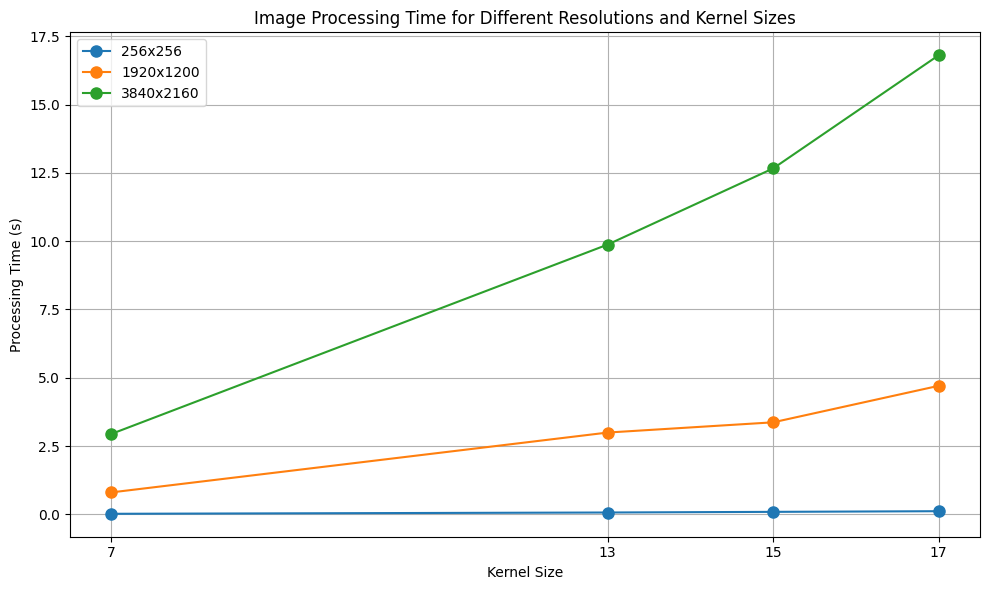

In [59]:
import matplotlib.pyplot as plt

# Data for different image resolutions
resolutions = ["256x256", "1920x1200", "3840x2160"]

# Data for processing times corresponding to different kernel sizes
kernel_sizes = [7, 13, 15, 17]

# Processing times for each resolution and kernel size
processing_times = [
    [0.021036, 0.068195, 0.092056, 0.116104],
    [0.804126, 2.995063, 3.369317, 4.705112],
    [2.944086, 9.876870, 12.663888, 16.805064]
]

# Plotting
plt.figure(figsize=(10, 6))

for i in range(len(resolutions)):
    plt.plot(kernel_sizes, processing_times[i], marker='o', label=f"{resolutions[i]}", linestyle='-', markersize=8)

plt.xlabel('Kernel Size')
plt.ylabel('Processing Time (s)')
plt.title('Image Processing Time for Different Resolutions and Kernel Sizes')
plt.xticks(kernel_sizes)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# GPU curve

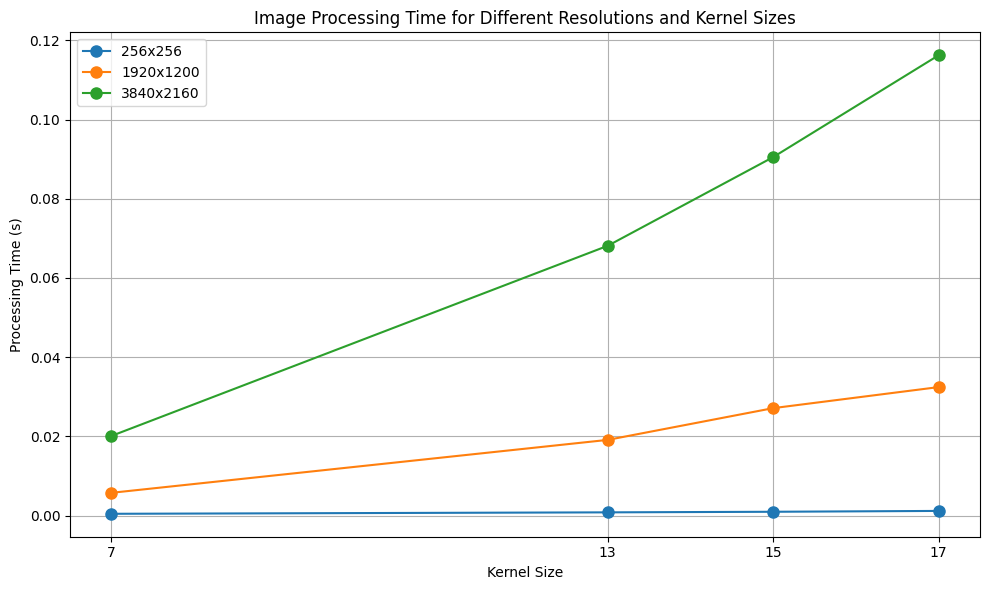

In [60]:
import matplotlib.pyplot as plt

# Data for different image resolutions
resolutions = ["256x256", "1920x1200", "3840x2160"]

# Data for processing times corresponding to different kernel sizes
kernel_sizes = [7, 13, 15, 17]

# Processing times for each resolution and kernel size
processing_times = [
    [0.000452, 0.000816, 0.000963, 0.001178],
    [0.005749, 0.019116, 0.027132, 0.032446],
    [0.020108, 0.068127, 0.090519, 0.116237]
]

# Plotting
plt.figure(figsize=(10, 6))

for i in range(len(resolutions)):
    plt.plot(kernel_sizes, processing_times[i], marker='o', label=f"{resolutions[i]}", linestyle='-', markersize=8)

plt.xlabel('Kernel Size')
plt.ylabel('Processing Time (s)')
plt.title('Image Processing Time for Different Resolutions and Kernel Sizes')
plt.xticks(kernel_sizes)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# CPU vs GPU

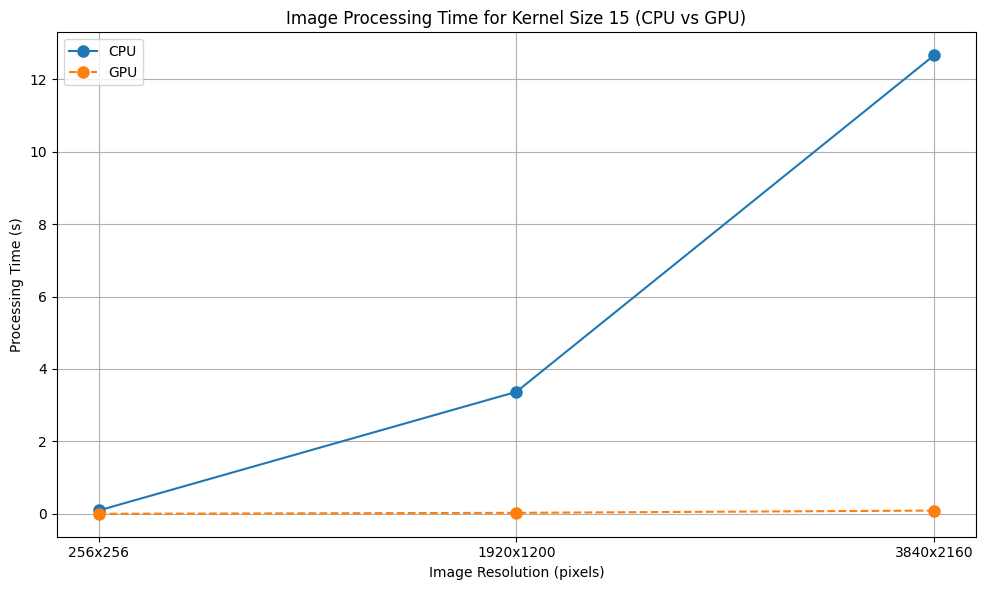

In [61]:
import matplotlib.pyplot as plt

# Data for CPU processing times
cpu_resolutions = ["256x256", "1920x1200", "3840x2160"]
cpu_processing_times = [0.092056, 3.369317, 12.663888]

# Data for GPU processing times
gpu_resolutions = ["256x256", "1920x1200", "3840x2160"]
gpu_processing_times = [0.000963, 0.027132, 0.090519]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(cpu_resolutions, cpu_processing_times, marker='o', label="CPU", linestyle='-', markersize=8)
plt.plot(gpu_resolutions, gpu_processing_times, marker='o', label="GPU", linestyle='--', markersize=8)

plt.xlabel('Image Resolution (pixels)')
plt.ylabel('Processing Time (s)')
plt.title('Image Processing Time for Kernel Size 15 (CPU vs GPU)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Speedup

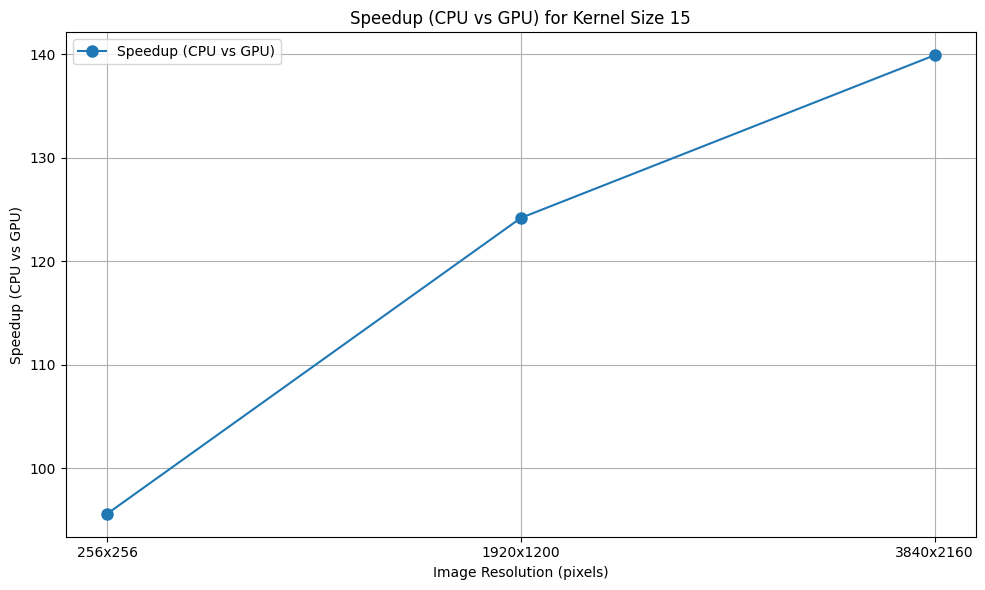

In [62]:
import matplotlib.pyplot as plt

# Data for CPU processing times
cpu_resolutions = ["256x256", "1920x1200", "3840x2160"]
cpu_processing_times = [0.092056, 3.369317, 12.663888]

# Data for GPU processing times
gpu_resolutions = ["256x256", "1920x1200", "3840x2160"]
gpu_processing_times = [0.000963, 0.027132, 0.090519]

# Calculate speedup
speedup = [cpu_time / gpu_time for cpu_time, gpu_time in zip(cpu_processing_times, gpu_processing_times)]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(cpu_resolutions, speedup, marker='o', label="Speedup (CPU vs GPU)", linestyle='-', markersize=8)

plt.xlabel('Image Resolution (pixels)')
plt.ylabel('Speedup (CPU vs GPU)')
plt.title('Speedup (CPU vs GPU) for Kernel Size 15')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# GPU curve / Shared Memory

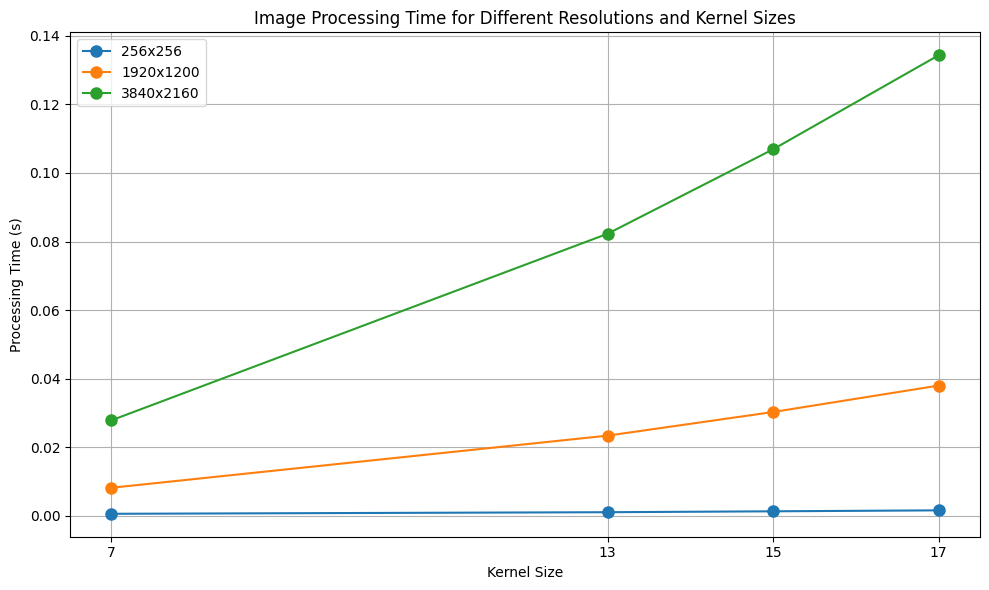

In [63]:
import matplotlib.pyplot as plt

# Data for different image resolutions
resolutions = ["256x256", "1920x1200", "3840x2160"]

# Data for processing times corresponding to different kernel sizes
kernel_sizes = [7, 13, 15, 17]

processing_times = [
    [0.000608, 0.001072, 0.001334, 0.001612],  # 256x256
    [0.008197, 0.023408, 0.030297, 0.038006],  # 1920x1200
    [0.027867, 0.082299, 0.106925, 0.134335]   # 3840x2160
]

# Plotting
plt.figure(figsize=(10, 6))

for i in range(len(resolutions)):
    plt.plot(kernel_sizes, processing_times[i], marker='o', label=f"{resolutions[i]}", linestyle='-', markersize=8)

plt.xlabel('Kernel Size')
plt.ylabel('Processing Time (s)')
plt.title('Image Processing Time for Different Resolutions and Kernel Sizes')
plt.xticks(kernel_sizes)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# CPU vs GPU / Shared Memory

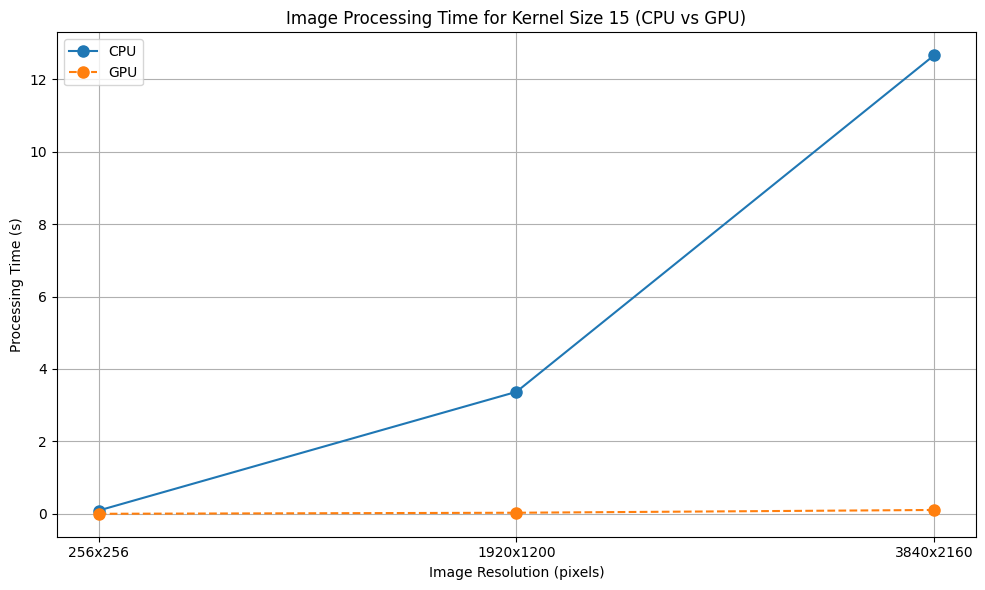

In [64]:
import matplotlib.pyplot as plt

# Data for CPU processing times
cpu_resolutions = ["256x256", "1920x1200", "3840x2160"]
cpu_processing_times = [0.092056, 3.369317, 12.663888]

# Data for GPU processing times
gpu_resolutions = ["256x256", "1920x1200", "3840x2160"]
gpu_processing_times = [0.001334, 0.030297, 0.106925]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(cpu_resolutions, cpu_processing_times, marker='o', label="CPU", linestyle='-', markersize=8)
plt.plot(gpu_resolutions, gpu_processing_times, marker='o', label="GPU", linestyle='--', markersize=8)

plt.xlabel('Image Resolution (pixels)')
plt.ylabel('Processing Time (s)')
plt.title('Image Processing Time for Kernel Size 15 (CPU vs GPU)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Speedup / Shared Memory

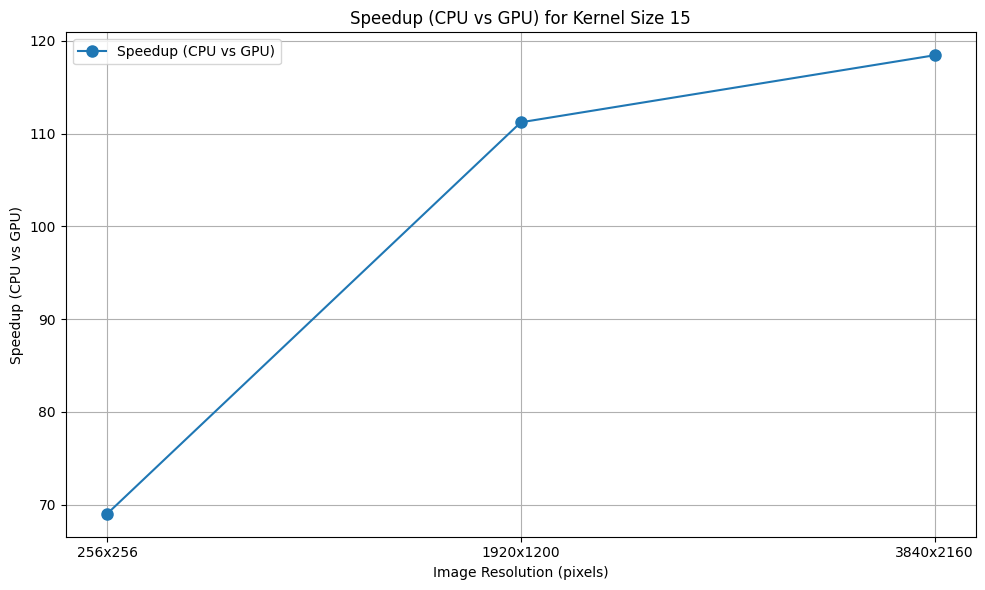

In [65]:
import matplotlib.pyplot as plt

# Data for CPU processing times
cpu_resolutions = ["256x256", "1920x1200", "3840x2160"]
cpu_processing_times = [0.092056, 3.369317, 12.663888]

# Data for GPU processing times
gpu_resolutions = ["256x256", "1920x1200", "3840x2160"]
gpu_processing_times = [0.001334, 0.030297, 0.106925]

# Calculate speedup
speedup = [cpu_time / gpu_time for cpu_time, gpu_time in zip(cpu_processing_times, gpu_processing_times)]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(cpu_resolutions, speedup, marker='o', label="Speedup (CPU vs GPU)", linestyle='-', markersize=8)

plt.xlabel('Image Resolution (pixels)')
plt.ylabel('Speedup (CPU vs GPU)')
plt.title('Speedup (CPU vs GPU) for Kernel Size 15')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Parallel Processing With And Without Shared Memory

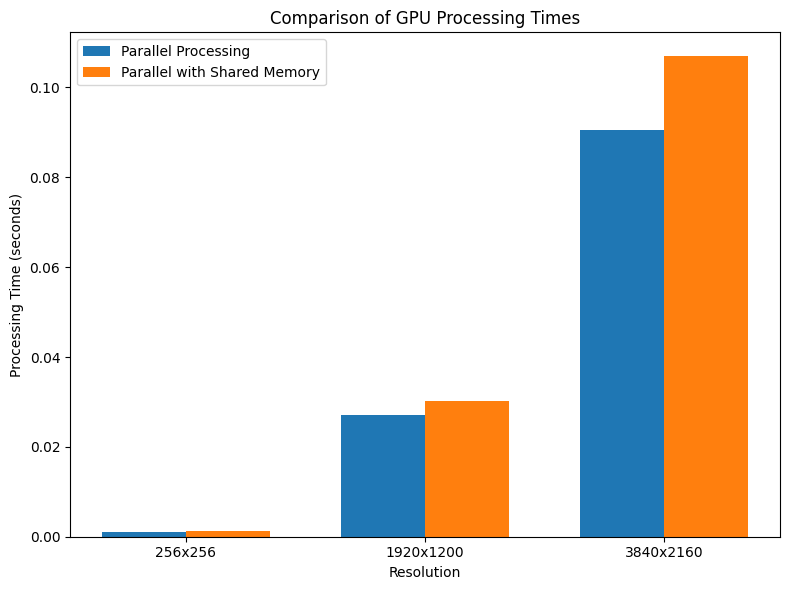

In [66]:
# Data for parallel processing (without shared memory)
gpu_resolutions = ["256x256", "1920x1200", "3840x2160"]
gpu_processing_times_parallel = [0.000963, 0.027132, 0.090519]

# Data for parallel processing with shared memory
gpu_processing_times_shared = [0.001334, 0.030297, 0.106925]

# Create a bar plot with the data
plt.figure(figsize=(8, 6))
bar_width = 0.35  # Width of the bars
index = range(len(gpu_resolutions))

# Plotting the bars
plt.bar(index, gpu_processing_times_parallel, bar_width, label='Parallel Processing')
plt.bar([i + bar_width for i in index], gpu_processing_times_shared, bar_width, label='Parallel with Shared Memory')

# Labeling the graph
plt.xlabel("Resolution")
plt.ylabel("Processing Time (seconds)")
plt.title("Comparison of GPU Processing Times")
plt.xticks([i + bar_width / 2 for i in index], gpu_resolutions)  # Align the x-ticks with the bars
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()